# The Bird Reservoir

## Présentation du dataset

Il s'agit d'un ensemble de données d'enregistrements sonores d'oiseaux, un sous-ensemble spécifique recueilli à partir de la collection Xeno Canto pour former un ensemble de données équilibré couvrant 88 espèces couramment entendues au Royaume-Uni.

Lien vers les données : https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset

In [1]:
%pip install librosa soundfile

Note: you may need to restart the kernel to use updated packages.


In [323]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from sklearn.metrics import accuracy_score, confusion_matrix



In [3]:
# Téléchargement des données
df = pd.read_csv("..//songs//birdsong_metadata.csv") # Remplacez par le chemin correct vers le fichier CSV
df.head()
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 264 rows and 10 columns


In [4]:
# Prise de connaissance des données
df.head(5)

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


Le "genus", l'espèce et le nom anglais sont équivalents. Nous utiliserons le "genus" comme label principal.

In [149]:
# Fonction de chargement et de traitement audio
def load_audio(file_id):
    data, samplerate = sf.read("../songs/songs/xc"+str(file_id)+".flac")
    s = len(data)/samplerate
    sg = librosa.feature.melspectrogram(
        y=data,
        sr=samplerate,
        hop_length=1024)
    
    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()
    
    # Filter out all frames with energy less than 2.5% of M
    mask = sg.mean(axis=0)>=M/40

    # Dilation du masque
    dil_mask = mask.copy()
    dil_sample = 40
    for i in range(len(mask)):
        if i > dil_sample:
            dil_mask[i] = max((mask[i-dil_sample:i+1]))

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*1024:] = dil_mask[i]
    return sg, dil_mask, data, audio_mask, samplerate

## Visualisation et prétraitement des fichiers audios

In [150]:
# Test de la fonction load_audio
sg, mask, data, audio_mask, sr = load_audio(99299)

print("Sampling rate :", sr)
print("Durée (s) :", len(data)/sr)
print("Spectrogram shape :", sg.shape)

Sampling rate : 44100
Durée (s) : 31.007120181405895
Spectrogram shape : (128, 1336)


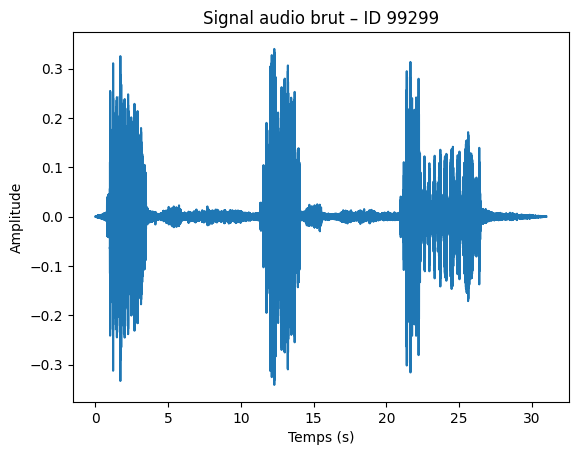

In [143]:
# Plot du signal temporel
t = np.arange(len(data)) / sr

plt.figure()
plt.plot(t, data)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.title("Signal audio brut – ID 99299")
plt.show()

### Visualisation du spectrogramme Mel
L’échelle Mel est logarithmique à haute fréquence et linéaire à basse fréquence.
Elle permet de voir le son comme l’oreille humaine, compressé et exploitable pour un modèle. Ce qui constitue donc un input convenable à notre algorithme de classification

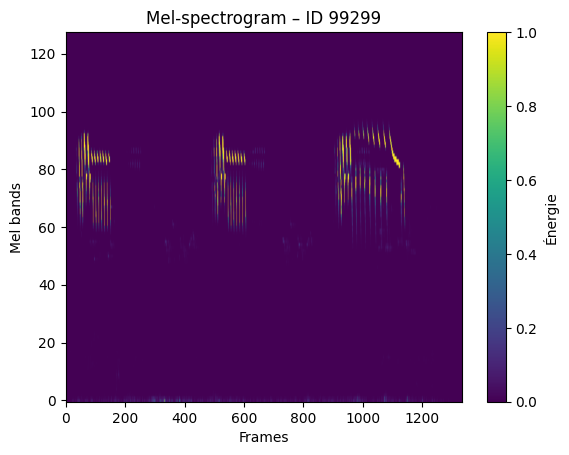

In [151]:
plt.figure()
plt.imshow(
    sg,
    aspect="auto",
    origin="lower",
    vmin=0,     # valeur min affichée
    vmax=1,  # valeur max affichée
    cmap="viridis"
)
plt.colorbar(label="Énergie")
plt.xlabel("Frames")
plt.ylabel("Mel bands")
plt.title("Mel-spectrogram – ID 99299")
plt.show()

##### Visualisation masque d'énérgie

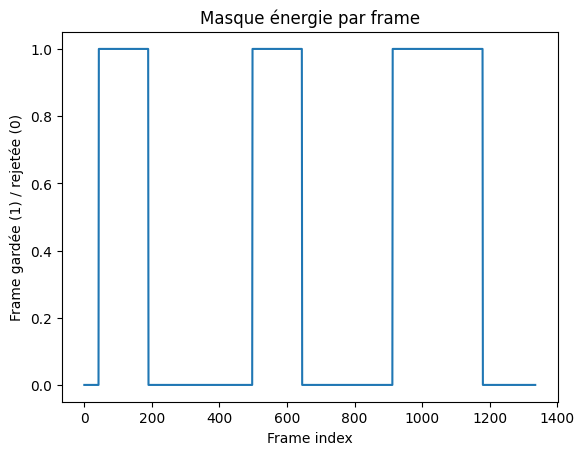

In [152]:
plt.figure()
plt.plot(mask.astype(int))
plt.xlabel("Frame index")
plt.ylabel("Frame gardée (1) / rejetée (0)")
plt.title("Masque énergie par frame")
plt.show()

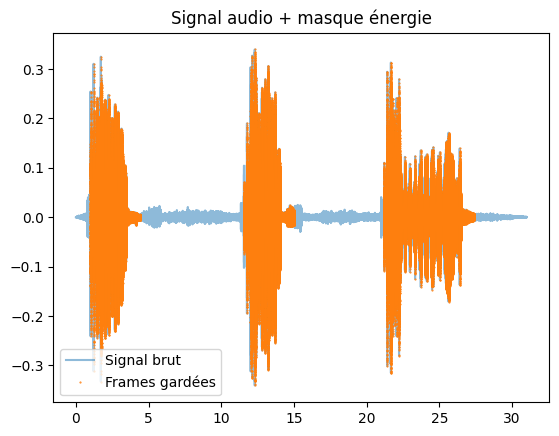

In [153]:
# Masque projeté sur le signal temporel
plt.figure()
plt.plot(t, data, label="Signal brut", alpha=0.5)
plt.plot(t[audio_mask], data[audio_mask], '.', label="Frames gardées", markersize=1)
plt.legend()
plt.title("Signal audio + masque énergie")
plt.show()

Le masque permet de séparer les parties “actives” du son. Il garde uniquement les frames dont l’énergie est ≥ 2.5% de l'amplitude moyenne. Ce qui permet de differencier si un oiseau chante ou non.

In [450]:

def list_unique_tags(df, tag_column="tag"):
    tags = (
        df[tag_column]
        .dropna()                      # remove NaN rows
        .str.split(", ")               # split tags
        .explode()                     # one tag per row
        .str.strip()                   # safety: remove extra spaces
        .str.lower()
        .unique()                      # unique values
    )
    return sorted(tags)

all_tags = ['nothing'] # Tag representant le silence (aucun oiseau entendu)
all_tags += list_unique_tags(df,'species')
all_tags += ['song','female','male','flight call','call']

def tags_to_vector(tag_string, all_tags):
    tag_set = set(tag_string.lower().split(", "))
    return [1 if tag in tag_set else 0 for tag in all_tags]

def vector_to_tags(vec,all_tags,thres = 0.5):
    res = []
    vec_size = len(vec)
    for i in range(vec_size):
        if(vec[i] > thres):
            res.append(all_tags[i])
    return ", ".join(res)

all_tags

['nothing',
 'aguimp',
 'alpina',
 'aluco',
 'apiaster',
 'apivorus',
 'apricaria',
 'apus',
 'argentatus',
 'arvensis',
 'ater',
 'atra',
 'atricapilla',
 'borin',
 'caeruleus',
 'calandra',
 'canadensis',
 'cannabina',
 'canorus',
 'carduelis',
 'caudatus',
 'chloris',
 'chloropus',
 'citrinella',
 'coelebs',
 'colchicus',
 'collybita',
 'communis',
 'corax',
 'corone',
 'curruca',
 'curvirostra',
 'decaocto',
 'domesticus',
 'europaea',
 'europaeus',
 'familiaris',
 'flammea',
 'flava',
 'fluviatilis',
 'frugilegus',
 'gallinago',
 'glandarius',
 'glareola',
 'iliacus',
 'lagopus',
 'livia',
 'major',
 'martius',
 'megarhynchos',
 'merula',
 'modularis',
 'monedula',
 'montanus',
 'oenas',
 'oriolus',
 'ostralegus',
 'palumbus',
 'palustris',
 'perdix',
 'philomelos',
 'phoenicurus',
 'pica',
 'pratensis',
 'pyrrhula',
 'regulus',
 'ridibundus',
 'rubecula',
 'rustica',
 'schoeniclus',
 'schoenobaenus',
 'scirpaceus',
 'sibilatrix',
 'squatarola',
 'stellata',
 'striata',
 'torquill

On souhaite applique cette liste de tags aux fichiers audios

## Chargement et étiquetage des fichiers audios

In [428]:
# Chargement et étiquetage des fichiers audios
df['length'] = np.zeros(len(df))

X = []
Y = []

id = 0
for file_id in df['file_id']:
    sg, mask, data, audio_mask, sample_rate = load_audio(file_id)
    X.append(sg)
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])

    y = []
    tags_vec = tags_to_vector(df['species'][id] + ", " + df['type'][id] ,all_tags)
    empty_vec = [0 for i in range(len(all_tags))]
    empty_vec[0] = 1
    for m in mask: # On marque les tags seulement lorque qqch est audible dans le fichier
        if m >= 0.75:
            y.append(tags_vec)
        else:
            y.append(empty_vec)
    y = [list(row) for row in zip(*y)] # Transposition
    Y.append(y)
    # print(len(data[audio_mask])/sample_rate)
    id += 1

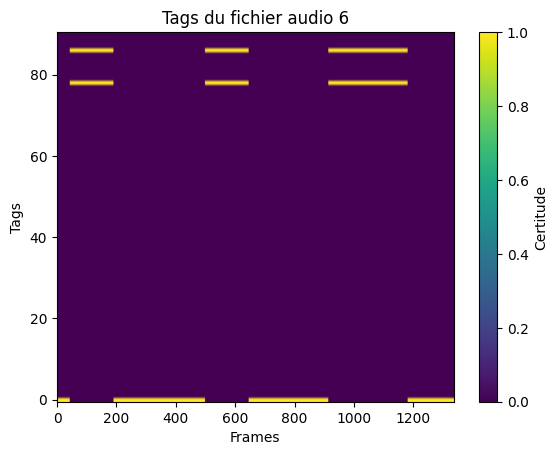

In [429]:
plt.figure()
plt.imshow(
    Y[23],
    aspect="auto",
    origin="lower",
    vmin=0,     # valeur min affichée
    vmax=1,  # valeur max affichée
    cmap="viridis"
)
plt.colorbar(label="Certitude")
plt.xlabel("Frames")
plt.ylabel("Tags")
plt.title("Tags du fichier audio 6")
plt.show()

Sur le graphique ci dessus, sont dessinés les tags en fonction du temps. Lorsque l'oiseau ne chante pas, le tag incertitude est activé. Cela certifie que rien ne peut être déterminer. Cela permet d'identifier le bruit comme du bruit. Lorsque l'oiseau chante sont espéce est révélé et l'incertitude réduite à 0.

## Classification avec un réservoir

### Séparation données d'entrainement et de validation
Chaques espèce d'oiseau possède trois enregistrements à la suite l'un de l'autre dans le dataset. Pour chaque espèce, on prend un enregistrement comme validation, et le reste pour l'entrainement. Cela permet d'avoir un entrainement et une validation sur chaque espèce. Permettant une classifaction correcte. Les autres tags sont distribués aléatoirement est constituent un objectif de classification secondaire, donc ils ne sont pas pris en compte dans la séparation.

In [430]:
# Transposition pour avoir les mêmes conventions que reservoir.py
for i in range(len(X)):
    X[i] = np.array([list(row) for row in zip(*X[i])], dtype=np.float64) # Transposition
for i in range(len(Y)):
    Y[i] = np.array([list(row) for row in zip(*Y[i])], dtype=np.float64) # Transposition

X_val = X[::3] # 1 sur 3
X_train = [x for i in range(0, len(X), 3) for x in X[i+1:i+3]] # 2 sur 3

Y_val = Y[::3]
Y_train =  [x for i in range(0, len(Y), 3) for x in Y[i+1:i+3]] # 2 sur 3


### Creation du modèle réservoir
On cherche à créer un modèle de séquence à séquence, puisque dans l'idéal on souhaiterait analyser un signal en temps continue. Ce qui veut dire que l'on cherche à obtenir les tags détectés par notre algorithme à tout moment.

In [431]:
from reservoirpy.nodes import Reservoir, Ridge, Input
from reservoirpy import set_seed
set_seed(42)

source = Input()
reservoir = Reservoir(2048, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-1)

model = [source >> reservoir, source] >> readout

Puisque on analyse des chant d'oiseau. On analyse des signaux entre-coupés de silence, il est donc dans notre intérét de conserver un leak rate assez bas afin de ne pas "oublier trop vite" qu'un oiseau chante lorsque l'on se trouve entre deux notes.
Pour trouver les paramètres actuels, nous avons essayé plusieurs configurations aléatoires et avons conservé celle qui donnait les meilleurs résultats en qui concerne la classification d'espèces. Dû à la demande en temps et en calculs nous avons fait que quelques itérations.
Pour obtenir un algorithme prêt à la production, il serait pertinent, de lancer une recherche aléatoire automatisée pendant plusieurs heures, afin de balayer davantage de configurations pour affiner les résultats.

### Entrainement et inférence

In [432]:
Y_pred = model.fit(X_train, Y_train, warmup=2).run(X_val)

### Validations des résultats

#### Classification de l'espèce

In [442]:
Y_pred_class = [np.argmax(y_p[:,:-5], axis=1) for y_p in Y_pred]
Y_val_class = [np.argmax(y_t[:,:-5], axis=1) for y_t in Y_val]

score = accuracy_score(np.concatenate(Y_val_class, axis=0), np.concatenate(Y_pred_class, axis=0))

print("Accuracy : ", f"{score * 100:.3f} %")

Accuracy :  54.398 %


La précision semble assez élevé si l'on considère le nombre élevée d'espèces à classifier. Cependant il faut aussi tenir compte que la précision est trés probablement "boostée" par le simple fait que le modèle arrive bien à détecter quand aucun oiseau ne chante.

In [443]:
cm = confusion_matrix(np.concatenate(Y_val_class, axis=0), np.concatenate(Y_pred_class, axis=0))
print(cm)

[[89040     0     0 ...     0     0     0]
 [  573     0     0 ...     0     0     0]
 [   12     0     0 ...     0     0     0]
 ...
 [ 2063     0     0 ...   150     0     0]
 [  208     0     0 ...     0     0     0]
 [  617     0     0 ...     0     0     0]]


In [446]:
print(cm[6:12,0:12])

[[ 2939     0     0     0     0     0   154     0     0     0     0     0]
 [  131     0     0     0     0     0     0    28     0     0     0     0]
 [  190     0     0    54     0     0     0     0  1117     0     0     8]
 [    5     0     0     0     0     0     0     0     0 10327     0     0]
 [  432     0     0     0     0     0     0     8     0     0     0     0]
 [  236     0     0    18     0     0     0     0     0     0     0   160]]


On peut observer dans la matrice de confusion beaucoup de faux négatif, davantage que de faux positif. On observe aussi trés peu de confusion entre deux espèces d'oiseau. De plus certains oiseaux ne sont jamais identifiés. Notre hypothése est que en cas d'incertitude entre plusieurs espèces oiseaux, aucun score n'est assez élevé pour l'emporter sur celui du tag 'incertain' qui doit probablement toujours rester à une certaine valeur plus ou moins constante dû à son manque de forme exacte.

Cependant certains oiseaux sont détectés avec un degrés de succés assez élevé, comme le numéro 9 qui est l' Arvensis

#### Classification de l'intention

##### Call song

In [436]:
Y_pred_class = [1 if y_p_t[-1] >= 0.5 else 0 for y_p in Y_pred for y_p_t in y_p]
Y_val_class = [1 if y_t_t[-1] >= 0.5 else 0 for y_t in Y_val for y_t_t in y_t]

score = accuracy_score(Y_val_class, Y_pred_class)

print("Accuracy : ", f"{score * 100:.3f} %")

cm = confusion_matrix(Y_val_class, Y_pred_class)
print(cm)

Accuracy :  84.275 %
[[197019  12263]
 [ 26120   8685]]


##### Flight Call song

In [437]:
Y_pred_class = [1 if y_p_t[-2] >= 0.5 else 0 for y_p in Y_pred for y_p_t in y_p]
Y_val_class = [1 if y_t_t[-2] >= 0.5 else 0 for y_t in Y_val for y_t_t in y_t]

score = accuracy_score(Y_val_class, Y_pred_class)

print("Accuracy : ", f"{score * 100:.3f} %")

cm = confusion_matrix(Y_val_class, Y_pred_class)
print(cm)

Accuracy :  95.780 %
[[231752   1602]
 [  8699   2034]]


Malgrés un pourcentage de précision élevé, la matrice de confusion montre un taux d'erreur important.

##### Female/Male

Regardons la classification mâle/femelle des oiseaux, on assigne l'indice 0 à aucun oiseau, l'indice 1 pour mâle seulement, l'indice 2 pour femelle seulement, l'indice 3 pour les deux en même temps

In [438]:
Y_pred_class = [(3 if y_p_t[-4] >= 0.5 else 1) if y_p_t[-3] >= 0.5 else (2 if y_p_t[-4] >= 0.5 else 0) for y_p in Y_pred for y_p_t in y_p]
Y_val_class = [(3 if y_t_t[-4] >= 0.5 else 1) if y_t_t[-3] >= 0.5 else (2 if y_t_t[-4] >= 0.5 else 0) for y_t in Y_val for y_t_t in y_t]

score = accuracy_score(Y_val_class, Y_pred_class)

print("Accuracy : ", f"{score * 100:.3f} %")

cm = confusion_matrix(Y_val_class, Y_pred_class)
print(cm)

Accuracy :  79.472 %
[[166327   7561     81     35]
 [ 36434  24694      0     42]
 [  1892    306      0      0]
 [  3088    606     61   2960]]


On remarque que aucune femelle seule a été correctement identifiée, cela peut être lié au manque de données. En effet on observe que la somme de la colonne d'indice 2 est trés faible comparé au reste.

### Conclusion

Les résultats sont cohérents. Les erreurs semblent liées à une incertitute trop grande typique d'un manque d'entrainement plûtot qu'une erreur de méthode (trés peu de confusion entre espèce, avec des cas de réussite).

Il est clair que nous avons besoin de beaucoup plus de données pour atteindre des résultats satisfaisants. Pour une telle tâche de classification trois enregistrements par espèces est beaucoup trop peu (1 min 30 d'enregistrement environ pour chaque). Cependant nos résultats montrent tout même le potentiel d'une méthode de machine learning tel que le Réservoir computing. 